# Data Analysis
Notebook overview:
- data loading
- visualization
- adding indicators
- normalization methods
- exporting to .csv files

First we start off with exploring and analysing our data.

Using: pandas, numpy, seaborn.

In [1]:
import pandas as pd
import numpy as np
from utils import *

# Data Loading
## NASDAQ

In [2]:
data_dir = '../data/'
nasdaq = pd.read_csv(data_dir + 'NASDAQ/Composite-2015-2019-D1.csv')

In [3]:
nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,4726.810059,1435150000
1,2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,4652.569824,1794470000
2,2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,4592.740234,2167320000
3,2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,4650.470215,1957950000
4,2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,4736.189941,2105450000


## Adj Close
According to Yahoo! Finance specification:
- *Close* -- Close price adjusted for splits.
- *Adj Close* -- Adjusted close price adjusted for both dividends and splits.

We can see that these two columns have exact same values. Let's check whether it is true for the whole dataset and drop if it is.

In [4]:
close = np.array(nasdaq['Adj Close'])
adj_close = np.array(nasdaq['Close'])

In [5]:
len(nasdaq) - (close == adj_close).sum()

0

In [6]:
nasdaq.drop(['Adj Close'], axis=1, inplace=True)

In [7]:
nasdaq = nasdaq.set_index('Date')

In [8]:
nasdaq.index = pd.to_datetime(nasdaq.index)

We can scale Volume column down:

In [9]:
nasdaq.loc[:, 'Volume'] = nasdaq.loc[:,'Volume'] / 1e9

In [10]:
nasdaq.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,1.43515
2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,1.79447
2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,2.16732
2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,1.95795
2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,2.10545


## EURUSD

In [11]:
eurusd = load_file_split(data_dir + 'EURUSD/')

In [12]:
eurusd.tail()

,Date,Time,Open,High,Low,Close,Ticks
1458710,2019.11.29,16:54,1.10176,1.10202,1.10174,1.10200,0
1458711,2019.11.29,16:55,1.10199,1.10218,1.10149,1.10149,0
1458712,2019.11.29,16:56,1.10173,1.10174,1.10173,1.10173,0
1458713,2019.11.29,16:57,1.10173,1.10174,1.10173,1.10173,0
1458714,2019.11.29,16:58,1.10157,1.10174,1.10157,1.10158,0


Do we need Ticks column?

In [13]:
eurusd[eurusd['Ticks'] != 0]

,Date,Time,Open,High,Low,Close,Ticks


In [14]:
eurusd.drop(['Ticks'], axis=1, inplace=True)

### Change timeframe
Because current size of the EURUSD dataset is large, it is best to change the timeframe to a longer one: 1H (hourly started candle).

> This operation may take some time

In [15]:
eurusd = change_timeframe(eurusd)

In [16]:
len(eurusd), len(nasdaq)

(24312, 1259)

In [17]:
eurusd.loc[:,'Date'] = eurusd.loc[:,'Date'] + ' ' + eurusd.loc[:,'Time']
eurusd.drop(['Time'], inplace=True, axis=1)
eurusd = eurusd.set_index('Date')

In [18]:
eurusd.index = pd.to_datetime(eurusd.index)

In [19]:
eurusd.head()

,Open,High,Low,Close
Date,,,,
2016-01-03 18:02:00,1.08701,1.08723,1.08633,1.08639
2016-01-03 19:02:00,1.08639,1.08650,1.08451,1.08557
2016-01-03 20:02:00,1.08544,1.08577,1.08432,1.08443
2016-01-03 21:02:00,1.08462,1.08688,1.08272,1.08644
2016-01-03 22:02:00,1.08661,1.08756,1.08583,1.08715


# Visualization & exploration
To easily plot financial history data `mplfinance` module will be needed.

In [20]:
!pip install mplfinance

fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
%matplotlib inline

## Volume
For NASDAQ we have access to Volume, which indicates the number of changed shares. This can be used as additional information holder.

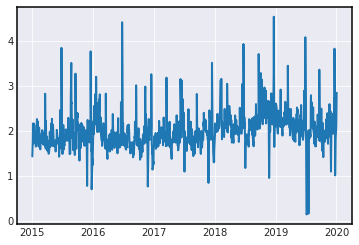

In [22]:
plt.plot(nasdaq.loc[:,'Volume'])

# Full market data

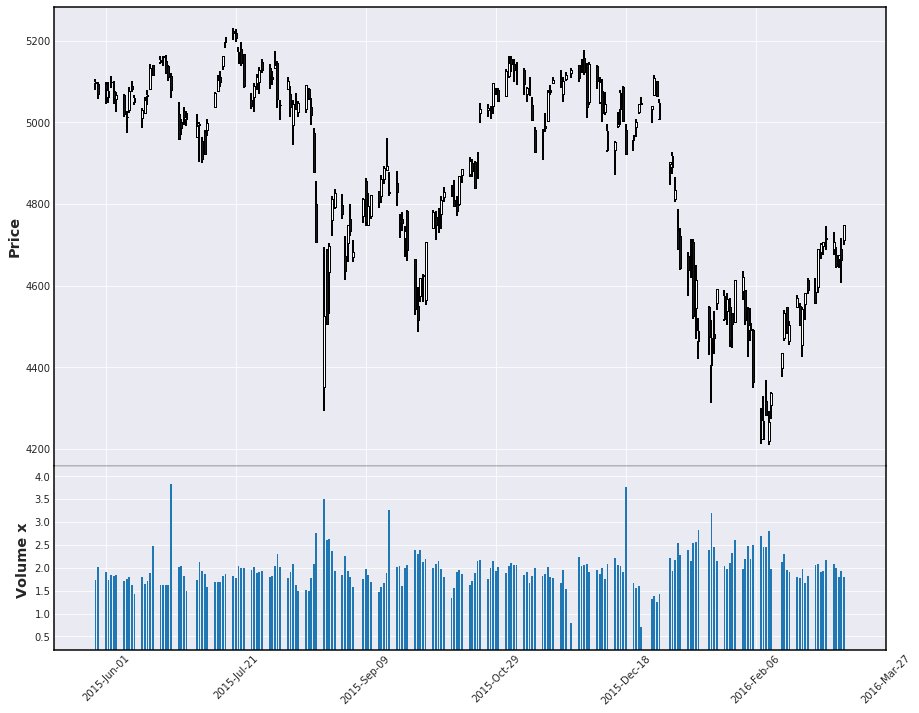

In [23]:
mpf.plot(nasdaq.iloc[100:300], type='candle', volume=True, no_xgaps=False, figscale=1.5)

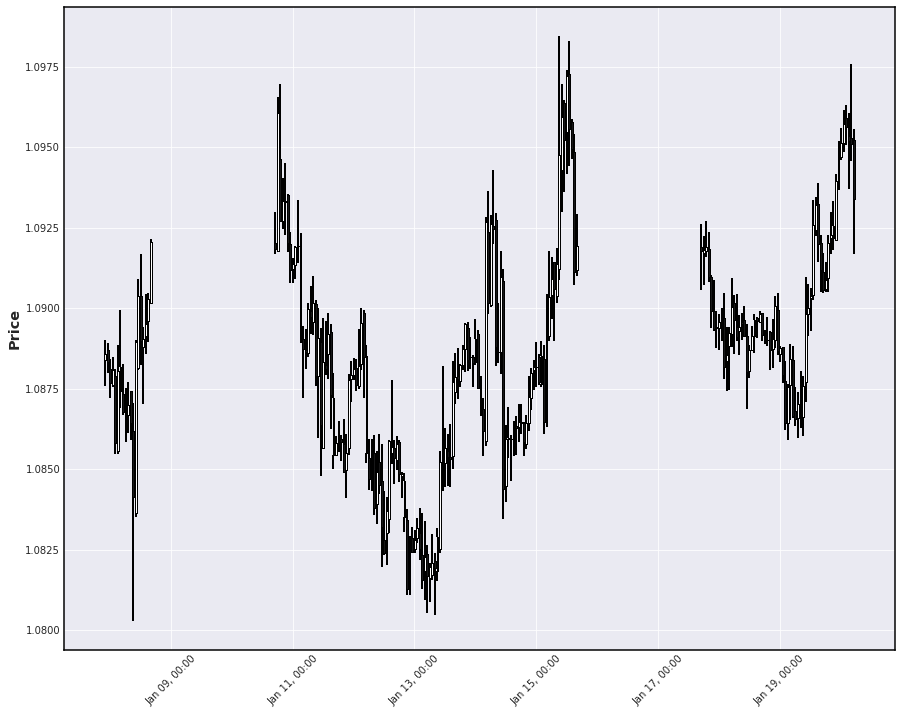

In [24]:
mpf.plot(eurusd.iloc[100:300], type='candle', no_xgaps=False, figscale=1.5)

## Values distribution
Normal distribution is a favourite of ML models. What we can see is that Volume is already well distributed. EURUSD looks quite decent, but it still has abnormally infrequent values. NASDAQ on the other hand definetely needs some transformation, since it is nowhere close to normal distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2edbb3ba20>,
      dtype=object)

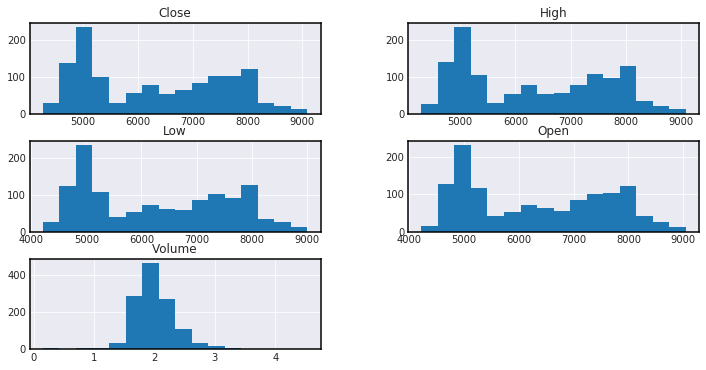

In [25]:
nasdaq.hist(figsize=(12,6), bins=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2edb9739e8>,
      dtype=object)

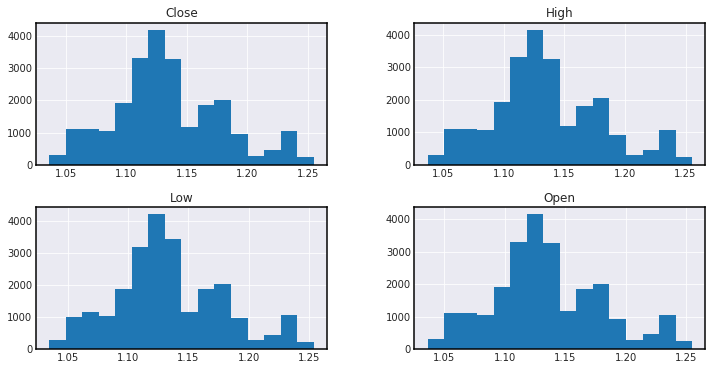

In [26]:
eurusd.hist(figsize=(12,6), bins=16)

# Indicators
Using this data, we can calculate any indicator we want. Some are implemented in the `indicators` module, which you can find in this project.

> **Warning:** applying indicators can take a long time! They are based on an iterative algorithms and the dataset is very large.

In [12]:
import indicators
# SMA(N=5)
# EMA(P=0.5)
# Momentum()
# RSI(period=14)

In [13]:
nasdaq = indicators.EMA(nasdaq, P=0.04)
nasdaq = indicators.SMA(nasdaq, N=50)
nasdaq = indicators.Momentum(nasdaq)
nasdaq = indicators.RSI(nasdaq, period=14)

In [16]:
nasdaq.head(30)

,Open,High,Low,Close,Volume,EMA,SMA,Momentum,RSI
Date,,,,,,,,,
2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,1.43515,4726.810059,4726.810059,0.000000,0.000000
2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,1.79447,4723.840450,4726.810059,-74.240235,0.000000
2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,2.16732,4718.596441,4689.689942,-59.829590,0.000000
2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,1.95795,4715.871392,4657.373372,57.729981,0.000000
2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,2.10545,4716.684134,4655.647583,85.719726,-75.622346
2015-01-09,4744.470215,4744.709961,4681.240234,4704.069824,1.71583,4716.179562,4671.756055,-32.120117,1529.333813
2015-01-12,4714.069824,4715.810059,4650.649902,4664.709961,1.86196,4714.120777,4677.141683,-39.359863,-630.818930
2015-01-13,4708.740234,4751.339844,4624.279785,4661.500000,2.16218,4712.015946,4675.365723,-3.209961,-230.997553
2015-01-14,4610.759766,4655.370117,4595.979980,4639.319824,2.07381,4709.108101,4673.632507,-22.180176,-219.644124


In [37]:
eurusd = indicators.EMA(eurusd, P=0.02)
eurusd = indicators.SMA(eurusd, N=100)
eurusd = indicators.Momentum(eurusd)
eurusd = indicators.RSI(eurusd, period=14)

In [54]:
eurusd.head(10)

,Open,High,Low,Close,EMA,SMA,Momentum,RSI
Date,,,,,,,,
2016-01-03 18:02:00,1.08701,1.08723,1.08633,1.08639,1.086390,1.086390,0.00000,0.000000
2016-01-03 19:02:00,1.08639,1.08650,1.08451,1.08557,1.086374,1.086390,-0.00082,0.000000
2016-01-03 20:02:00,1.08544,1.08577,1.08432,1.08443,1.086335,1.085980,-0.00114,0.000000
2016-01-03 21:02:00,1.08462,1.08688,1.08272,1.08644,1.086337,1.085463,0.00201,0.000000
2016-01-03 22:02:00,1.08661,1.08756,1.08583,1.08715,1.086353,1.085708,0.00071,80.079681
2016-01-03 23:02:00,1.08726,1.08728,1.08669,1.08711,1.086368,1.085996,-0.00004,81.927711
2016-01-04 00:02:00,1.08716,1.08834,1.08693,1.08822,1.086405,1.086182,0.00111,79.532164
2016-01-04 01:02:00,1.08764,1.09048,1.08740,1.08925,1.086462,1.086473,0.00103,82.721382
2016-01-04 02:02:00,1.08957,1.09024,1.08844,1.08918,1.086517,1.086820,-0.00007,84.375000


## Correlations

Not really needed here, as you can see below. It is obvious that price values are strongly correlated. What we want to look at is correlation with `Volume` and indicators.

We want to provide our model with useful input. That is why the weaker the correlation the better are the indicies.

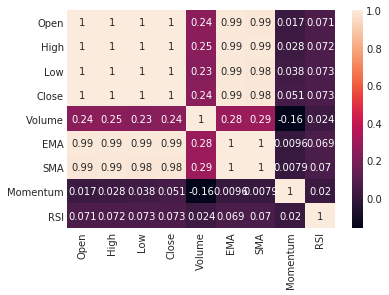

In [42]:
sns.heatmap(nasdaq.corr(), annot=True)

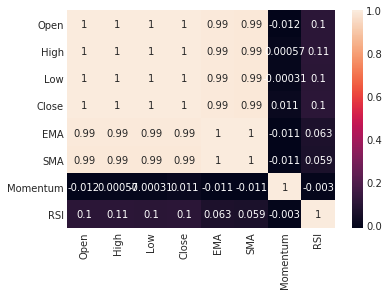

In [39]:
sns.heatmap(eurusd.corr(), annot=True)

# Simplified forecast
We can make prediction problem easier -- predict the close price only.

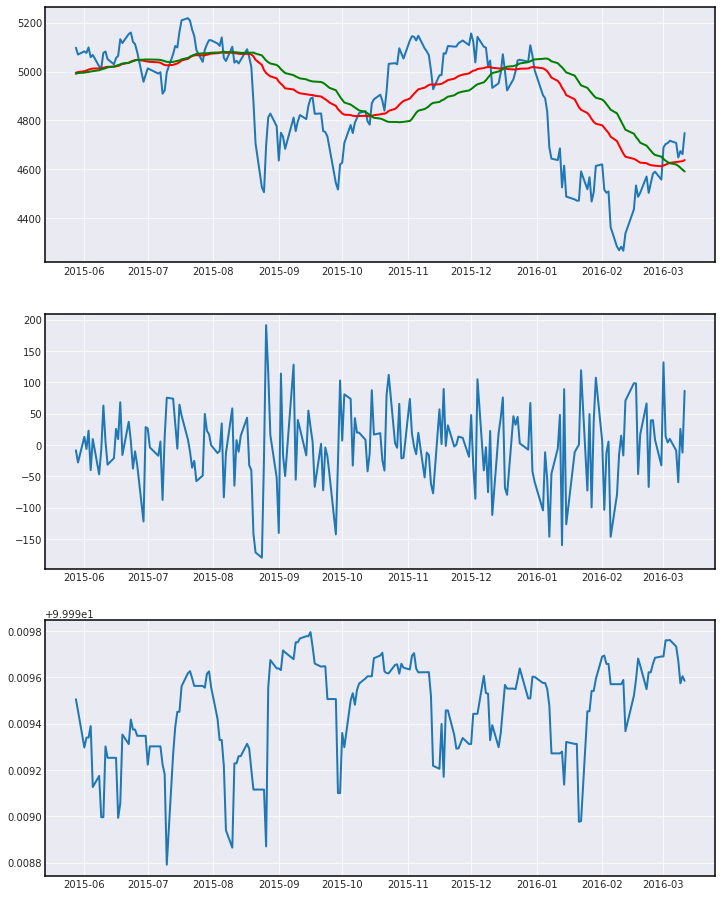

In [61]:
plt.figure(figsize=(12,16))
plt.subplot(311)
plt.plot(nasdaq.iloc[100:300, nasdaq.columns.get_loc('Close')])
plt.plot(nasdaq.iloc[100:300, nasdaq.columns.get_loc('EMA')], 'r')
plt.plot(nasdaq.iloc[100:300, nasdaq.columns.get_loc('SMA')], 'g')
plt.subplot(312)
plt.plot(nasdaq.iloc[100:300, nasdaq.columns.get_loc('Momentum')])
plt.subplot(313)
plt.plot(nasdaq.iloc[100:300, nasdaq.columns.get_loc('RSI')])

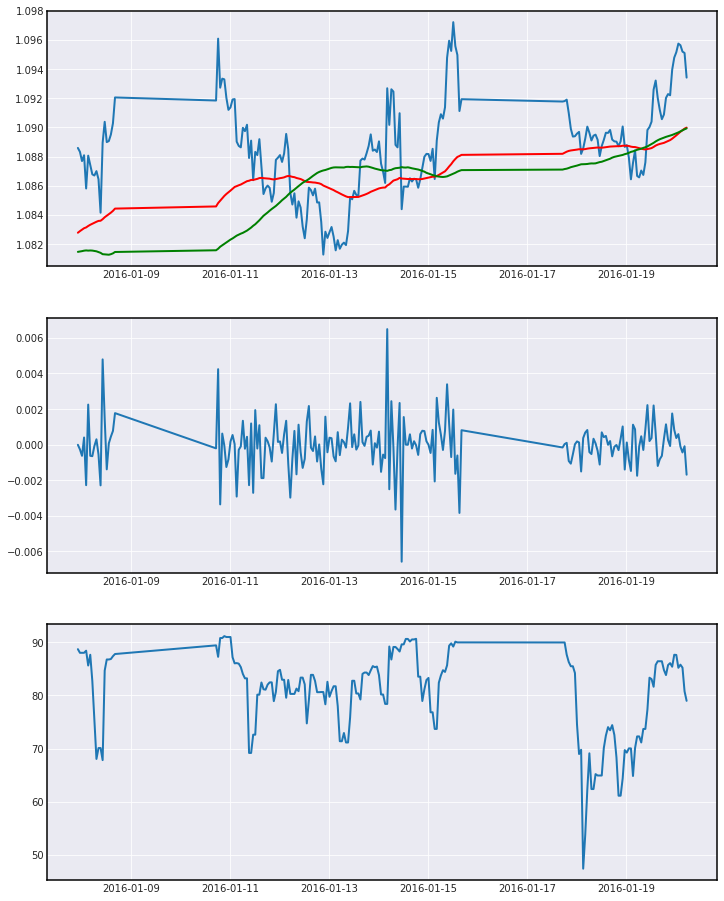

In [62]:
plt.figure(figsize=(12,16))
plt.subplot(311)
plt.plot(eurusd.iloc[100:300, eurusd.columns.get_loc('Close')])
plt.plot(eurusd.iloc[100:300, eurusd.columns.get_loc('EMA')], 'r')
plt.plot(eurusd.iloc[100:300, eurusd.columns.get_loc('SMA')], 'g')
plt.subplot(312)
plt.plot(eurusd.iloc[100:300, eurusd.columns.get_loc('Momentum')])
plt.subplot(313)
plt.plot(eurusd.iloc[100:300, eurusd.columns.get_loc('RSI')])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59882284a8>,
      dtype=object)

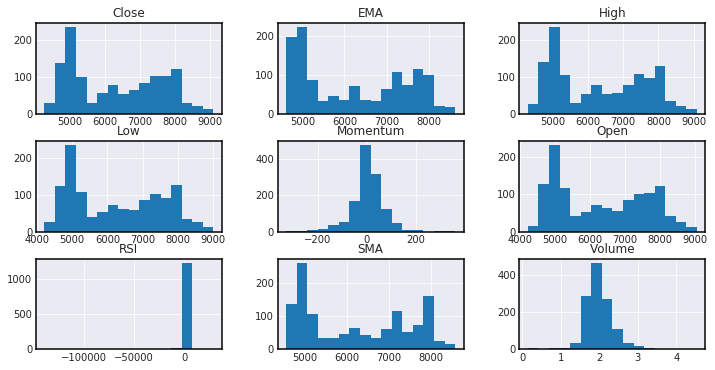

In [15]:
nasdaq.hist(figsize=(12,6), bins=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f1ea6e048>,
      dtype=object)

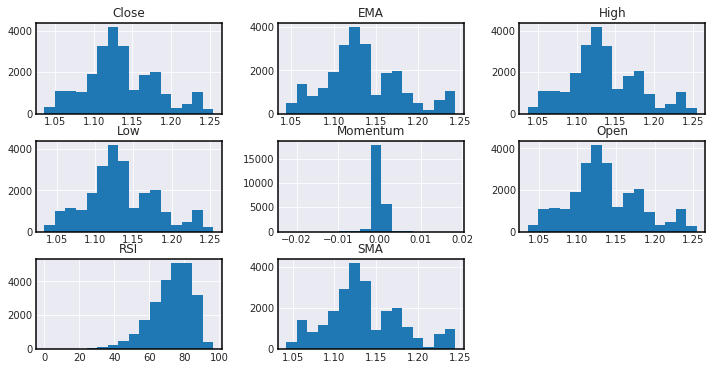

In [64]:
eurusd.hist(figsize=(12,6), bins=16)

# Normalization
We need to solve normalization problem discovered above. Here we will compare different normalization approaches:

Trainable:
- Convolution
- Batch normalization

Hyperparametrized:
- Moving Average

## 1. Convolution example
This is an example of how a trained filter may look like:

> **Note:** The first 2 entries should be removed! Here they were left behind to make the process easier to apply inplace.

In [ ]:
def conv(cf, data):
    for col in range(0, len(data.columns)):
        for i in range(2, len(data)):
            filtered = np.array(data.iloc[i-2:i, col]) @ cf
            data.iloc[i, col] = filtered
    return data

In [ ]:
conv_filter = np.array([0.2, -1, 0.8])
conv_eurusd = eurusd.iloc[100:200].copy()
conv_eurusd = conv(conv_filter, conv_eurusd)

# Export to CSV
Save our datasets to `train.csv` and `test.csv` files.